In [1]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

(9900,)


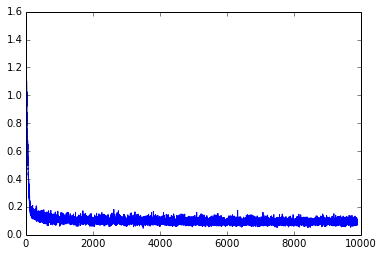

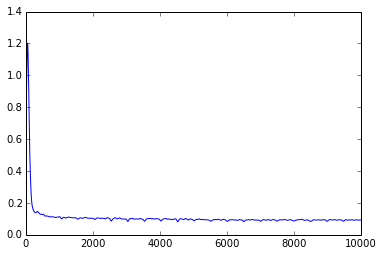

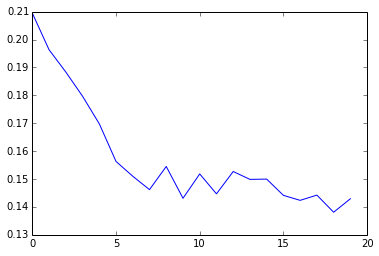

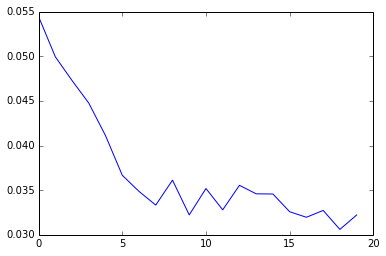

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

data = np.load("./data/resunet_f3d_berhu_epoch_20_loss_train.npy")

print data.shape

plt.plot(data)
plt.show()

plt.plot(smooth(data, window_len=100))
plt.show()

val = np.load("./data/resunet_f3d_berhu_epoch_20_loss_val.npy")
plt.plot(val)
plt.show()

val = np.load("./data/resunet_f3d_berhu_epoch_20_errors_val.npy")
plt.plot(val)
plt.show()

In [42]:
import h5py as h
import numpy as np
import matplotlib.pyplot as plt

f = h.File("/data/data/f3d-train.hdf5")
images = np.array(f["images"][0:400])
print images.shape
depths = np.array(f["depths"][0:400])

(400, 3, 240, 320)


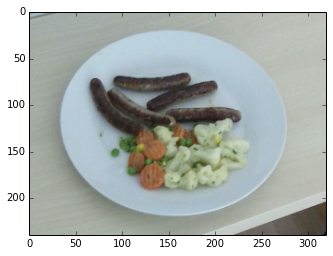

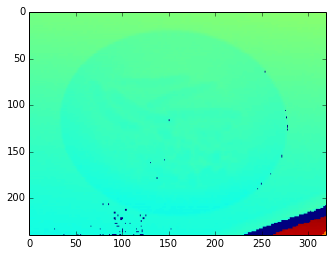

0.62773


In [4]:
%matplotlib inline

idx = 15

plt.imshow(images[idx].transpose((1,2,0)))
plt.show()
plt.imshow(depths[idx])
plt.show()

print depths[idx].mean()


In [5]:
ls data

resunet_connected_berhu_epoch_120.npz
resunet_connected_berhu_epoch_120_errors_val.npy
resunet_connected_berhu_epoch_120_loss_train.npy
resunet_connected_berhu_epoch_120_loss_val.npy
resunet_connected_mse_epoch_60.npz
resunet_connected_mse_epoch_60_errors_val.npy
resunet_connected_mse_epoch_60_loss_train.npy
resunet_connected_mse_epoch_60_loss_val.npy
resunet_f3d_berhu_epoch_20.npz
resunet_f3d_berhu_epoch_20_errors_val.npy
resunet_f3d_berhu_epoch_20_loss_train.npy
resunet_f3d_berhu_epoch_20_loss_val.npy
resunet_f3d_berhu_low_thresh_epoch_30.npz
resunet_f3d_berhu_low_thresh_epoch_30_errors_val.npy
resunet_f3d_berhu_low_thresh_epoch_30_loss_train.npy
resunet_f3d_berhu_low_thresh_epoch_30_loss_val.npy
resunet_f3d_epoch_60.npz
resunet_f3d_epoch_60_errors_val.npy
resunet_f3d_epoch_60_loss_train.npy
resunet_f3d_epoch_60_loss_val.npy


In [97]:
import theano
import theano.tensor as T
import lasagne 
import numpy as np
from networks import residual_unet

model = "./data/resunet_connected_berhu_epoch_120.npz"

# Build net
input_var = T.tensor4('inputs')
network = residual_unet(input_var=input_var, connectivity=4)

prediction = lasagne.layers.get_output(network, deterministic=True)

fn = theano.function([input_var], [prediction])
with np.load(model) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)


In [20]:
def test_image_idx(idx):
    test_image = images[idx].copy().astype(np.float32)
    test_depth = depths[idx].copy().astype(np.float32)

    mean = np.load("/data/data/f3d-train.npy").astype(np.float32)
    test_image -= mean
    test_image /= 71.571201304890508
    excerpt = test_image[:,6:234,8:312]
    excerpt = excerpt[np.newaxis,:,:,:]

    pred = fn(excerpt)[0].squeeze()

    exd = test_depth[6:234:2,8:312:2]
    
    diff = exd - pred
    diff[exd == 0] = 0
    diff[exd > 1.2] = 0
    mse = np.mean(diff**2)
    return (mse, pred)

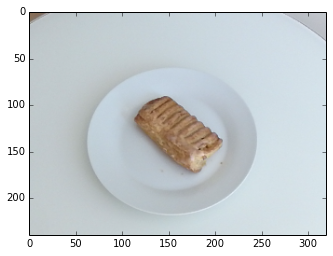

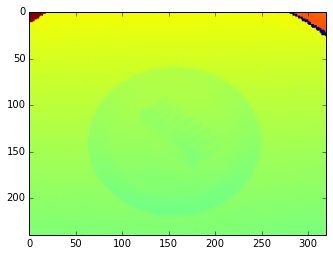

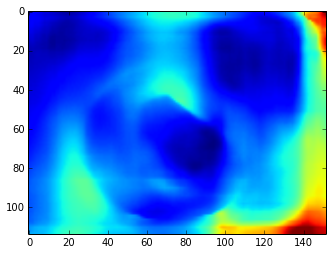

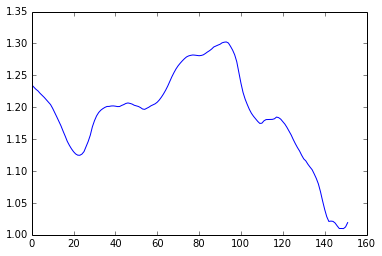

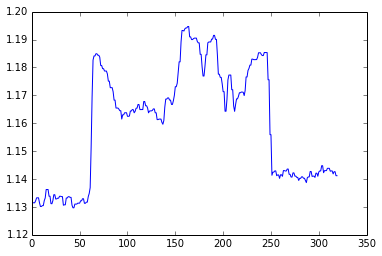

RMSE:  0.132825


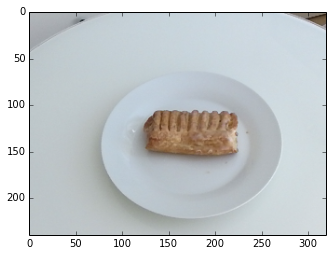

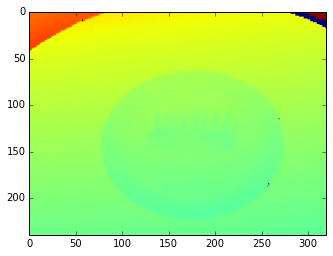

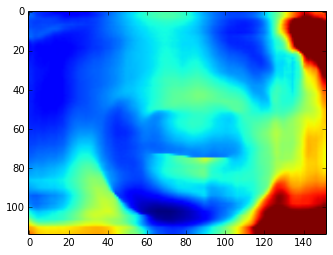

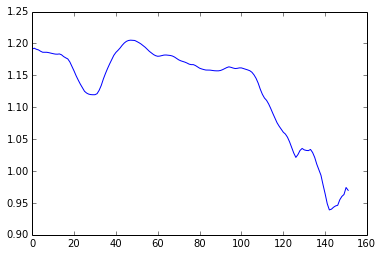

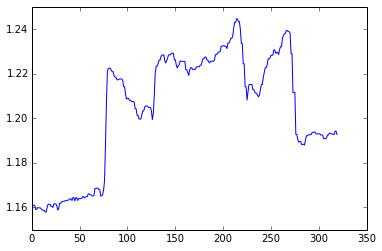

RMSE:  0.18233


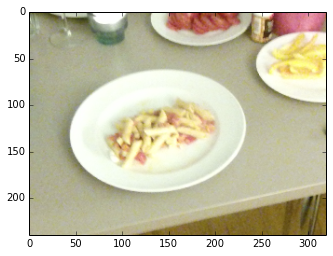

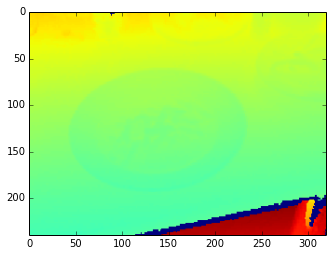

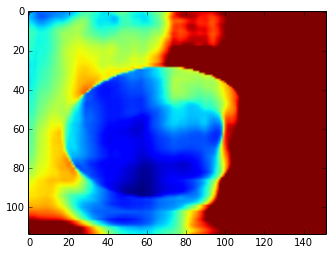

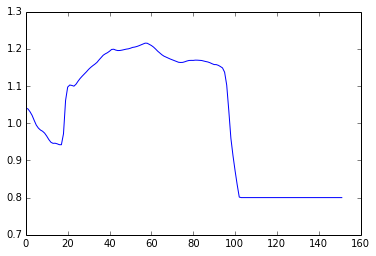

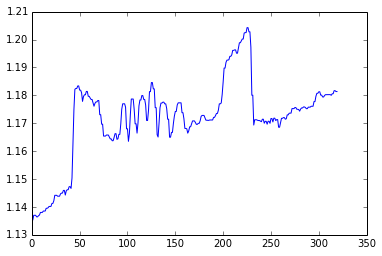

RMSE:  0.379915


In [104]:
## Showcase Test-Images
showcase = [67,73,50]

for i in showcase:
    plt.imshow(images[i].transpose((1,2,0)))
    plt.show()
    plt.imshow(depths[i])
    plt.show()
    mse, pred = test_image_idx(i)
    dclip = pred.clip(0,1.2)
    plt.imshow(dclip)
    plt.show()
    
    top = 2 - dclip[70,:]
    plt.plot(top)
    plt.show()
    
    topr = 2 - depths[i,140,:].clip(0,1.2)
    plt.plot(topr)
    plt.show()

    print "RMSE: ", np.sqrt(mse)